In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from collections import Counter
import matplotlib.pyplot as plt

## Dataset

In [2]:
transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor()])
cifar100 = datasets.CIFAR100(root="./data", train=True, download=True, transform=transform)

Files already downloaded and verified


In [3]:
data = cifar100.data.reshape(len(cifar100), -1) / 255.0  # Normalization
labels = np.array(cifar100.targets)
data, labels    # data: (50000, 3072)

(array([[1.        , 1.        , 1.        , ..., 0.54117647, 0.67843137,
         0.30980392],
        [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ],
        [0.98039216, 0.98039216, 0.97254902, ..., 0.90980392, 0.90196078,
         0.89411765],
        ...,
        [0.97254902, 0.95686275, 0.94901961, ..., 0.8       , 0.80392157,
         0.80392157],
        [0.61176471, 0.60392157, 0.5372549 , ..., 0.63921569, 0.60392157,
         0.49411765],
        [0.12156863, 0.2627451 , 0.47843137, ..., 0.15686275, 0.14509804,
         0.2627451 ]]),
 array([19, 29,  0, ...,  3,  7, 73]))

## Dimension Decrement

In [ ]:
# pca = PCA(n_components=50)
# data = pca.fit_transform(data)
# data   # (50000, 50)

## Kohonen

In [4]:
class Kohonen:
    def __init__(self, input_dim:int, map_size:tuple, sigma:float=1.0, lr:float=0.2):
        self.input_dim = input_dim
        self.map_size = map_size
        self.lr = lr
        self.sigma = sigma
        self.weights = torch.rand(map_size[0], map_size[1], input_dim)

    def gaussian_neighborhood(self, winner):
        grid_indexes = np.array([[np.array([i, j]) for j in range(self.map_size[1])] for i in range(self.map_size[0])])
        distances = np.linalg.norm(grid_indexes - np.array(winner), axis=2)
        return np.exp(-(distances**2)/ (2*self.sigma**2))

    def train(self, data, epochs):
        for epoch in range(epochs):
            print(f"epoch: {epoch + 1} / {epochs}")
            for item in data:
                item = torch.tensor(data=item, dtype=torch.float32).unsqueeze(0)
                
                distances = torch.cdist(item, self.weights.view(-1, self.input_dim))
                winner_index = torch.argmin(distances).item()
                winner_coordinates = np.unravel_index(winner_index, self.map_size)
                
                neighborhood = self.gaussian_neighborhood(winner_coordinates)
                neighborhood = torch.tensor(neighborhood, dtype=torch.float32).unsqueeze(-1)
                
                # print(self.weights.shape, neighborhood.shape, item.shape)
                self.weights += self.lr * neighborhood * (item - self.weights)

            self.sigma *= 0.99
            self.lr *= 0.99

    def map_data(self, data):
        mapped_data = []
        for item in data:
            item = torch.tensor(item, dtype=torch.float32).unsqueeze(0)
            distances = torch.cdist(item, self.weights.view(-1, self.input_dim))
            winner_idx = torch.argmin(distances).item()
            mapped_data.append(np.unravel_index(winner_idx, self.map_size))
        return np.array(mapped_data)
    
    def final_mapping(self, img_dim):
        kohonen_map = torch.zeros(
        (self.map_size[0] * img_dim[0], self.map_size[1] * img_dim[1], img_dim[2]),
        dtype=torch.uint8,
        )
        for i in range(self.map_size[0]):
            for j in range(self.map_size[1]):
                neuron_weights = self.weights[i, j]
                reshaped_weights = neuron_weights.view(img_dim)
                min_val, max_val = reshaped_weights.min(), reshaped_weights.max()
                if max_val != min_val:
                    normalized_weights = (
                    ((reshaped_weights - min_val) / (max_val - min_val)) * 255
                    ).to(torch.uint8)
                else:
                    normalized_weights = reshaped_weights.to(torch.uint8)
                    
                kohonen_map[
                    i * img_dim[0] : (i + 1) * img_dim[0],
                    j * img_dim[1] : (j + 1) * img_dim[1],
                    :
                ] = normalized_weights
                
        kohonen_map_np = kohonen_map.cpu().numpy()
        plt.figure(figsize=(10, 10))
        plt.imshow(kohonen_map_np)
        plt.axis("off")
        plt.title("Kohonen Map")
        plt.show()        

In [5]:
def compute_purity(mapped_positions, labels):
    cluster_labels = {}
    for idx, pos in enumerate(mapped_positions):
        pos = tuple(pos)
        if pos not in cluster_labels:
            cluster_labels[pos] = []
        cluster_labels[pos].append(labels[idx])

    total_correct = 0
    for pos, assigned_labels in cluster_labels.items():
        _, count = Counter(assigned_labels).most_common(1)[0]
        total_correct += count

    purity = total_correct / len(labels)
    print(f"Cluster Purity: {purity:.2%}")

## Let's Run the Model!

epoch: 1 / 10
epoch: 2 / 10
epoch: 3 / 10
epoch: 4 / 10
epoch: 5 / 10
epoch: 6 / 10
epoch: 7 / 10
epoch: 8 / 10
epoch: 9 / 10
epoch: 10 / 10


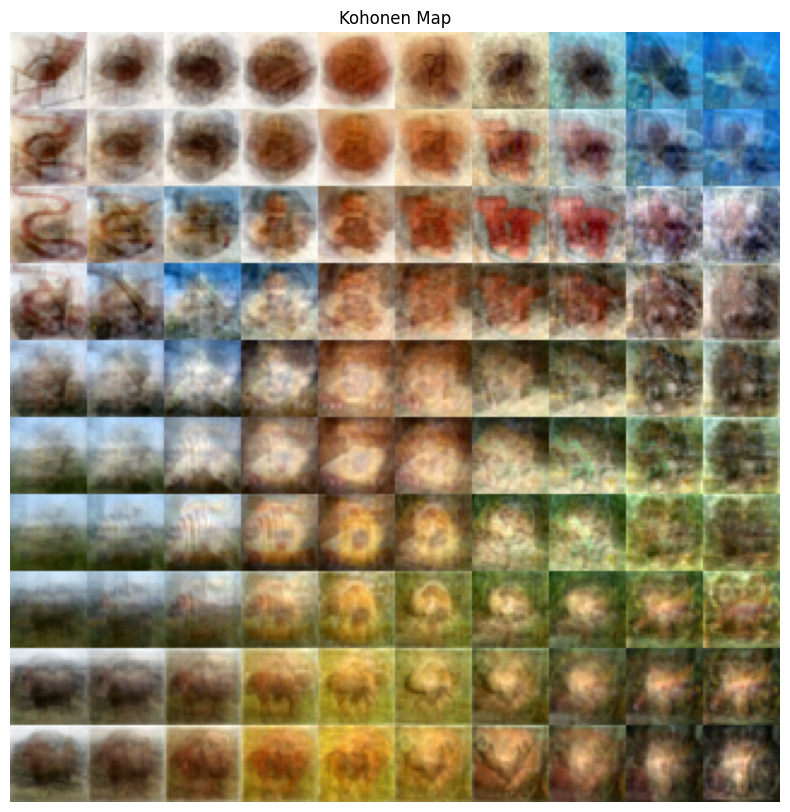

Cluster Purity: 7.52%


In [6]:
model = Kohonen(input_dim=3072, map_size=(10, 10), sigma=1, lr=0.2)

epochs = 10
model.train(data, epochs=epochs)

mapped_positions = model.map_data(data)

model.final_mapping(img_dim=(32,32,3))

compute_purity(mapped_positions, labels)